## Importing All Required Libraries

In [24]:
pip install keras_tuner

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras_tuner import RandomSearch
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. Nabil Bank (nabil) Stock Price Dataset

In [26]:
df = pd.read_csv('/content/drive/MyDrive/MSc. Dissertation/Dataset/nabil.csv')

In [27]:
df.head()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.0,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.0,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.0,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.0,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.0,352,"393,534.00"


In [28]:
df.tail()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"
3082,9/25/2024,550,560,545.1,555,0.27,"50,441.00","27,867,328.70"


In [29]:
df.duplicated().sum()

1

## Copying the dataset for future use

In [30]:
df1 = df.copy()
df1.reset_index(inplace=True)

### Dropping unwanted column

In [31]:
df.drop(['% Change', 'Turnover'], axis=1, inplace=True)
df = df.rename(columns = {
    'Ltp': 'Close',
    'Qty': 'Volume'
})

In [32]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float).astype(int)
df

,Date,Open,High,Low,Close,Volume
0,2011-03-20,1200.0,1190.0,1160.0,1170.0,853
1,2011-03-24,1162.0,1178.0,1150.0,1153.0,356
2,2011-03-25,1153.0,1174.0,1145.0,1174.0,702
3,2011-03-27,1174.0,1160.0,1120.0,1147.0,1426
4,2011-03-28,1147.0,1150.0,1110.0,1132.0,352
...,...,...,...,...,...,...
3078,2024-09-18,562.0,565.0,550.0,556.0,68886
3079,2024-09-22,556.0,578.0,556.0,562.0,55026
3080,2024-09-23,573.2,573.2,555.0,568.0,123568
3081,2024-09-24,567.0,567.0,552.1,553.5,66337


### Splitting into features and target

In [33]:
features = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

### Scaling the features

In [34]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features (Open, High, Low, Volume)
scaled_features = scaler_features.fit_transform(features)

# Scale the target (Close)
scaled_target = scaler_target.fit_transform(target)

### Convert to DataFrame to maintain indices

In [35]:
# Combine the scaled features and scaled target into a new DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Volume'])
scaled_data['Close'] = scaled_target  # Use the scaled Close values as the target

### Function to create sequences

In [36]:
sequence_length = 60
X = []
y = []
target_index = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[['Open', 'High', 'Low', 'Volume']].values[i-sequence_length:i])
    y.append(scaled_data['Close'].values[i])
    target_index.append(i)  # store index of each target value

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

### Splitting the data into train and test set

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, y_test_indices = train_test_split(target_index, test_size=0.2, random_state=42)

### Model Building using CNN

In [38]:
def build_model(hp):
    model = Sequential()

    # Tune the number of units in each LSTM layer
    units_1 = hp.Int('units_1', min_value=64, max_value=128, step=32)
    units_2 = hp.Int('units_2', min_value=32, max_value=64, step=16)
    units_3 = hp.Int('units_3', min_value=25, max_value=50, step=25)

    # Tune dropout rate
    dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3])

    # Tune the dense layer units
    dense_units = hp.Choice('dense_units', values=[25, 50])

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Add LSTM layers with tuned units and dropout
    model.add(LSTM(units=units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units_2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units_3))

    # Add Dense layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))  # Single output for regression

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',  # Minimize validation loss
    max_trials=10,         # Number of hyperparameter combinations to try
    executions_per_trial=1, # Number of times to train each model
    directory='kt_tuner_dirs', # Directory to save logs
    project_name='lstm_stock_price'
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(X_train, y_train,
             validation_data=(X_test, y_test),
             epochs=50,
             callbacks=[early_stopping],
             batch_size=32)

Reloading Tuner from kt_tuner_dirs/lstm_stock_price/tuner0.json


In [39]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [40]:
# Make predictions on the test set
predictions = best_model.predict(X_test)
predictions.flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step


array([0.05958318, 0.17881194, 0.47584763, 0.33647427, 0.21572308,
       0.5834753 , 0.20385106, 0.32131577, 0.83045775, 0.06794121,
       0.7669346 , 0.7686097 , 0.30482253, 0.12569745, 0.45666552,
       0.61863756, 0.5334538 , 0.22979729, 0.5359239 , 0.5540041 ,
       0.83624715, 0.68635803, 0.20638312, 0.41811204, 0.6367729 ,
       0.7680787 , 0.8219749 , 0.16257972, 0.4417994 , 0.2078311 ,
       0.41493848, 0.44060555, 0.1465733 , 0.1666488 , 0.05672922,
       0.09815466, 0.11612383, 0.3559141 , 0.10974006, 0.15355602,
       0.4849516 , 0.23740885, 0.15201348, 0.18067122, 0.56792814,
       0.14780678, 0.45432684, 0.23400196, 0.2165723 , 0.12712575,
       0.06555456, 0.4445117 , 0.6409748 , 0.8097195 , 0.4485592 ,
       0.37101924, 0.14377028, 0.01678927, 0.3666931 , 0.7438723 ,
       0.02067405, 0.04192049, 0.63775575, 0.02384433, 0.43659204,
       0.19064829, 0.46547213, 0.06722608, 0.03660886, 0.16545413,
       0.15230672, 0.2791909 , 0.3635585 , 0.24854505, 0.18795

In [41]:
y_test

array([0.05979381, 0.17525773, 0.4871134 , 0.34278351, 0.20532646,
       0.56829897, 0.19458763, 0.32560137, 0.84106529, 0.08457904,
       0.80670103, 0.78135739, 0.30030069, 0.12328179, 0.45661512,
       0.62414089, 0.52749141, 0.22852234, 0.53393471, 0.55584192,
       0.86039519, 0.68298969, 0.22036082, 0.42869416, 0.6387457 ,
       0.74226804, 0.8024055 , 0.16237113, 0.45489691, 0.21821306,
       0.41408935, 0.44372852, 0.15292096, 0.17310997, 0.06013746,
       0.09755155, 0.10910653, 0.34879725, 0.1121134 , 0.14690722,
       0.48883162, 0.23539519, 0.14948454, 0.1911512 , 0.5661512 ,
       0.14862543, 0.47594502, 0.24828179, 0.20614261, 0.13316151,
       0.07216495, 0.44630584, 0.64991409, 0.7637457 , 0.46219931,
       0.38230241, 0.14213918, 0.00987973, 0.29381443, 0.74226804,
       0.02792096, 0.04252577, 0.62843643, 0.02276632, 0.45446735,
       0.1838488 , 0.47293814, 0.06958763, 0.03994845, 0.15592784,
       0.1621134 , 0.27491409, 0.36984536, 0.25167526, 0.18384

In [42]:
y_pred_inv = scaler_target.inverse_transform(predictions)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [43]:
prediction = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': y_pred_inv.flatten()}, index=y_test_indices)
for a in prediction.index:
    for b in df.index:
        if a == b:
            prediction['Date'] = df['Date']
prediction.set_index('Date', inplace=True)
prediction.sort_index(inplace=True)
prediction

,Actual,Predicted
Date,,
2011-06-27,1106.0,1275.661499
2011-07-07,1120.0,1101.259888
2011-07-18,1283.0,1268.364136
2011-07-28,1289.0,1254.659424
2011-08-10,1234.0,1218.192139
...,...,...
2024-09-10,569.8,585.775146
2024-09-11,561.5,578.767151
2024-09-16,561.2,560.709656


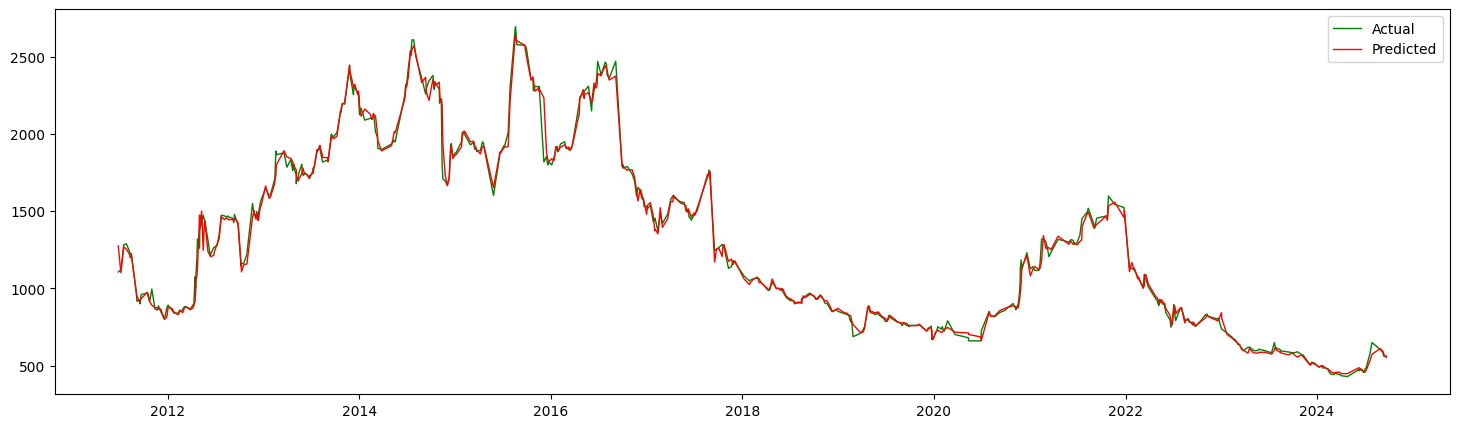

In [44]:
plt.figure(figsize=(18, 5))
plt.plot(prediction.Actual, label='Actual', color='g', linewidth=1)
plt.plot(prediction.Predicted, label='Predicted', color='r', linewidth=1)
plt.legend()
plt.show()


## Calculating the Performance Evaluation Metrics

In [45]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.00037087042343034545
Root Mean Squared Error: 0.01925799635035653
Mean Absolute Error: 0.010954202649249614


In [46]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 2009.9634981901208
Root Mean Squared Error: 44.83261645487715
Mean Absolute Error: 25.501384226901468
